# Exercise session 6: Gauss-Newton and Newton-Lagrange
### Preliminaries and problem set-up

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Latex  # Latex formatting for Python print statements

In [2]:
def line_search(fun, x0, dir_deriv, dk, sigma, beta):
    """
    Line search using the Armijo conditions and backtracking.

    Input arguments:
    - fun: scalar function
    - x0: current iterate
    - dir_deriv: directional derivative of f at x0 in the direction dk
    - dk: search direction
    - sigma: armijo condition scalar parameter
    - beta: backtracking parameter

    Returns:
    - x: new iterate
    - alpha: step size
    """

    # Make sure sigma and beta are in a reasonable range
    if not 0 < sigma < 1:
        raise ValueError(f'sigma must be in (0, 1), but equals {sigma}')
    if not 0 < beta < 1:
        raise ValueError(f'beta must be in (0, 1), but equals {beta}')

    max_iter_left = 1000

    # Initialize alpha, evaluate function
    alpha = 1.
    f0 = fun(x0)

    x = x0 + alpha * dk

    while fun(x) > f0 + sigma * alpha * dir_deriv:
        # Trial step in x
        alpha *= beta
        x = x0 + alpha * dk

        max_iter_left -= 1

        # If the line search takes too many iterations, throw an Exception
        if max_iter_left == 0:
            raise Exception('Line search failed -- Too many iterations.')

    return x, alpha

In [3]:
def finite_difference_jacob(fun, x0):
    """
    Evaluates the Jacobian of fun at x0 using finite differences.

    Input arguments:
    - fun: real- or vector-valued function
    - x0: current iterate

    Returns:
    - f0: fun evaluated at x0 (as a 1D array)
    - J: Jacobian of fun evaluated at x0 (as a matrix)
    """

    # Make sure x0 is a 1D array
    x0 = np.atleast_1d(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"
    Nx = len(x0)

    # Make sure fun returns a 1D array
    f0 = np.atleast_1d(fun(x0))
    assert f0.ndim == 1, "fun must return a scalar or a 1D array"
    Nf = len(f0)

    # Initialize empty J
    J = np.zeros((Nf, Nx))

    # Perform the finite difference Jacobian evaluation
    h = 1e-8  # finite difference step size
    for k in range(Nx):
        x = np.copy(x0)
        x[k] += h
        f = fun(x)
        J[:, k] = (f - f0) / h

    return f0, J

### Exercise 1: Gauss-Newton method
Let us consider the nonlinear least-squares (NLS) problem: $ \renewcommand\R{\mathrm{I\!R}} $
\begin{equation*}
	\min_{x\in\R^n}~ f(x)=\tfrac{1}{2}\|F(x)\|_2^2,
\end{equation*}
where $F(x)=(f_1(x),\dots,f_m(x))$ and $f_i:\R^n\rightarrow \R$ are sufficiently smooth. 

The gradient of $f$ is given by
$$
	\nabla f(x) = JF{x}^\top F(x),
$$
where $JF{x}$ is the Jacobian of $F$ at $x$.
If we linearize $F$ around $x$ we get
\begin{align*}
	F(x + \Delta x) \approx F(x) + JF{x}\Delta x.
\end{align*}
Therefore, we can approximate $\nabla f$ at the point $x+\Delta x$ by
\begin{equation} \tag{1.1}
	\nabla f(x+\Delta x) \approx JF{x}^\top F(x) + JF{x}^\top JF{x} \Delta x.
\end{equation}
When at point $x_k$, we can compute $x_{k+1} = x_k + \Delta x$ by setting $(1.1)$ equal to zero and solving for $\Delta x$.
Indicating $F_k = F(x_k)$ and $J_k = JF{x_k}$, that is
$$
	\Delta x = - (J_k^TJ_k)^{-1}J_k^T F_k.
$$
We already know how to do a linesearch, so let's use $\Delta x$ as our search direction $d_k$.
When you perform the linesearch, be sure you are evaluating the original function and gradient $f(x)$ and $\nabla f(x)$, and not $F(x)$ and $JF{x}$.

The Python function *ffun* evaluates the NLS objective for a given function $F$, denoted by *Ffun*, at a point $x$.


In [4]:
def ffun(Ffun, x):
    """
    Evaluates the nonlinear least-squares (NLS) objective

    Input arguments:
    - Ffun: nonlinear function
    - x: point to evaluate the NLS objective at

    Returns:
    - objective value
    """

    F = Ffun(x)
    return 0.5 * np.dot(F, F)

**Task 1a**: Implement a Gauss-Newton minimizer by completing the function *minimize_gn*. This minimizer takes in the function $F(x)$, represented by the argument *Ffun*, and an initial guess $x_0$.
		
* **Warning 1**:
    The provided *line_search* function has a slightly different prototype than last time: it is given $\nabla f_k^T d_k$ instead of $\nabla f_k$ as one of its arguments.

* **Warning 2**:
    The provided *finite_difference_jacob* always returns the Jacobian and not the gradient, regardless whether the function is real- or vector-valued. Therefore, in order to retrieve the gradient $\nabla f$, you need to transpose the Jacobian.


In [5]:
def minimize_gn(Ffun, x0, Ffun_jac=None):
    """
    Minimizes a nonlinear least-squares (NLS) objective
    using a Gauss-Newton method.

    Input arguments:
    - Ffun: nonlinear function
    - x0: Initial iterate

    Returns:
    - x: Final iterate
    - x_iters: Log of the iterates
    - x_grads: Log of the gradient norms
    """

    # Convergence tolerance
    grad_tol = 1e-4
    max_iters = 200

    # Make sure x0 is a 1D array
    x0 = np.asarray(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"

    # Make sure Ffun returns a 1D array
    f0 = np.asarray(Ffun(x0))
    assert f0.ndim == 1, "Ffun must return a 1D array"

    # Log of the iterations
    x_iters = np.zeros((len(x0), max_iters))
    grad_iters = np.zeros(max_iters)

    x = np.copy(x0)

    for k in range(max_iters):
        # Check for divergence
        if np.max(abs(x)) > 1e6:
            raise ValueError(f"minimize_gn has diverged, {np.max(abs(x))=}")

        # Evaluate F and its Jacobian J
        if Ffun_jac is not None:
            F = Ffun(x)
            J = Ffun_jac(x)
        else:
            F, J = finite_difference_jacob(Ffun, x)

        norm_grad = np.linalg.norm(J.T @ F, ord=np.inf)

        # Update the iteration log
        x_iters[:, k] = np.copy(x)
        grad_iters[k] = norm_grad

        display(Latex(rf"Iteration {k}: $\|J^\top F\|_\infty$ = {norm_grad}"))
        print(np.linalg.cond(J))

        # Check for convergence
        if norm_grad < grad_tol:
            return x, x_iters[:, 0 : k + 1], grad_iters[0 : k + 1]

        ###################### FILL THIS PART IN ####################

        # Find the search direction
        dk = -np.linalg.solve(J.T @ J, J.T @ F)
        f_grad = J.T @ F

        # Line search
        eval_f_fun = lambda x: ffun(Ffun, x)
        dir_deriv = np.dot(f_grad, dk)
        x, _ = line_search(eval_f_fun, x, dir_deriv, dk, sigma=0.01, beta=0.6)

        #############################################################

    raise ValueError(f"minimize_gn has diverged, maximum number of iterations reached.")

**Task 1b**: A typical problem solved by Gauss-Newton is nonlinear regression. We will fit monthly average temperatures using a sinusoidal model:
\begin{equation} \tag{1.2}
    T(k) = A \sin(\omega k + \phi) + C.
\end{equation}
Here $T$ denotes the average temperature for month $k$.
In particular, given a data set of $\{k_i,T_i\}$ pairs, the Gauss-Newton method minimizes the objective function:
\begin{equation} \tag{1.3}
    \min_{A, \omega, \phi, C}~ \tfrac 12\sum_i(T(k(i))-y_i)^2.
\end{equation}
Fit these data by completing the code below.
Try different initial points. What do you observe?

<!-- **A successful minimization should look like:
TO DO: Keep figure?** -->

In [6]:
def Ffun(x, k, y):
    """
    Evaluates the NLS objective for the sinusoidal model given by formula (1.2).

    Input arguments:
    - x: fitting parameters [A, w, phi, C]
    - k: the months data
    - y: the average temperature data

    Returns:
    - F: evaluates the NLS objective (1.2) at x
    """
    A, w, phi, C = x

    ###################### FILL THIS PART IN ####################
    F = A * np.sin(w * k + phi) + C - y
    #############################################################
    return F

def Ffun_jac(x, k, y):
    """
    Evaluates the Jacobian of the NLS objective for the sinusoidal model given by formula (1.2).

    Input arguments:
    - x: fitting parameters [A, w, phi, C]
    - k: the months data
    - y: the average temperature data

    Returns:
    - JF: Jacobian of the NLS objective (1.2) at x
    """
    A, w, phi, C = x

    J = np.zeros((len(y), len(x)))
    ###################### FILL THIS PART IN ####################
    J[:, 0] = np.sin(w * k + phi)
    J[:, 1] = k * A * np.cos(w * k + phi)
    J[:, 2] = A * np.cos(w * k + phi)
    J[:, 3] = np.ones_like(y)
    #############################################################
    return J

Fit the given average temperature data to a sinusoidal model using the Gauss-Newton method.

<IPython.core.display.Latex object>

86.52469648764753


<IPython.core.display.Latex object>

161.84156954428147


<IPython.core.display.Latex object>

542.6547665057421


<IPython.core.display.Latex object>

454.683863717524


<IPython.core.display.Latex object>

422.85146333349155


<IPython.core.display.Latex object>

376.95663366255843


<IPython.core.display.Latex object>

382.6660866392834


<IPython.core.display.Latex object>

381.7848076109365


<IPython.core.display.Latex object>

381.9171215230363


<IPython.core.display.Latex object>

381.8962463759199


<IPython.core.display.Latex object>

381.89936823726293


<IPython.core.display.Latex object>

381.8988744738725


<IPython.core.display.Latex object>

381.8989481414906


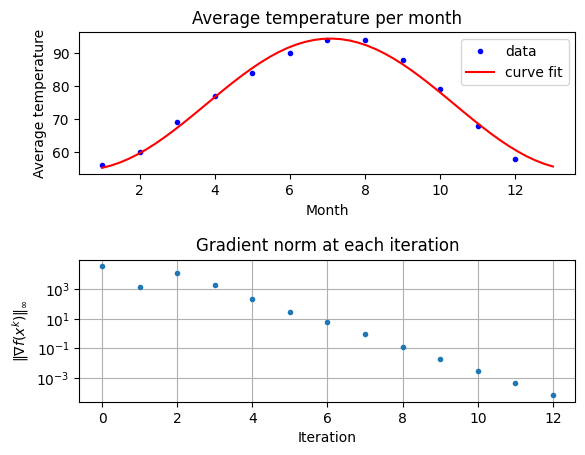

In [7]:
# Play around with different initial points x0.
# x0 = np.ones(4)
x0 = np.array([15, 0.4, 10 , 1])

k = np.array([i for i in range(1, 13)])
y = np.array([56, 60, 69, 77, 84, 90, 94, 94, 88, 79, 68, 58])
kc = np.linspace(1, 13, 52)

# Call Gauss-Newton implementation
eval_F_fun = lambda x: Ffun(x, k, y)
eval_F_jac = lambda x: Ffun_jac(x, k, y)
(A, w, phi, C), _, grad_iters = minimize_gn(eval_F_fun, x0, eval_F_jac)

# Create figure with two subplots
_, (ax1, ax2) = plt.subplots(2)

# Plot data and fitted model
ax1.plot(k, y, 'b.', label='data')
ax1.plot(kc, A * np.sin(w * kc + phi) + C, 'r', label = 'curve fit')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average temperature')
ax1.set_title('Average temperature per month')
ax1.legend()

# Plot gradient norms
ax2.semilogy(grad_iters, '.')
ax2.grid(True)
ax2.set_xlabel('Iteration')
ax2.set_ylabel(r'$\|\nabla f(x^k)\|_\infty$')
ax2.set_title('Gradient norm at each iteration')

# Adjust vertical separation between plots and plot results
plt.subplots_adjust(hspace=0.6)
plt.show()

### Exercise 2: Newton-Lagrange Method
Consider the problem:
\begin{equation} \tag{2.1}
	\min_{x\in \R^n}~f(x)
\quad\text{subject to}\quad
	h(x) = 0,
\end{equation}
where $f : \R^n \to \R$ and $h : \R^n \to \R^p$.
We handle the constraints by introducing the Lagrange multipliers $\lambda\in\R^p$ and the Lagrangian function:
$$
	L(x,\lambda) = f(x) + \lambda^{\top}h(x).
$$
Our goal is to solve the nonlinear system of equations $\nabla L(x,\lambda)=0$ defining the optimality conditions (KKT), namely
\begin{align*}
	0 = \nabla_xL(x,\lambda) &{}= \nabla f(x) + J h(x)^{\top} \lambda \\
	0 = \nabla_\lambda L(x,\lambda) &{}= h(x).
\end{align*}
We linearize this system around $(x_k, \lambda_k)$: denoting $f_k\coloneqq f(x_k)$, $h_k\coloneqq h(x_k)$, $x\coloneqq x_k + \Delta x$, $\lambda\coloneqq\lambda_k + \Delta \lambda$ and $L_k\coloneqq L(x_k,\lambda_k)$,
\begin{align*}
	\nabla_xL(x,\lambda)
{}\approx{} &
	\overbrace{
		\vphantom{X^{X^X}}\nabla_x L(x_k,\lambda_k)
	}^{
		\mathclap{\nabla f_k + Jh_k^{\top} \lambda_k}
	}
	{}+{}
	\overbrace{
		\nabla_x\left(\nabla_x L(x_k,\lambda_k)\right)^{\top}
	}^{\nabla_{xx}^2L_k}
	\Delta x
	{}+{}
	\overbrace{
		\nabla_\lambda\left(\nabla_x L(x_k,\lambda_k)\right)^{\top}
	}^{Jh_k^{\top}}
	\Delta\lambda
\\
{}={} &
	\nabla f_k + Jh_k^{\top}\lambda_k + \nabla_{xx}^2L_k\Delta x + Jh_k^{\top}(\lambda - \lambda_k)
\\
{}={} &
	 \nabla f_k + \nabla_{xx}^2L_k\Delta x + Jh_k^{\top} \lambda
\end{align*}
and
\begin{align*}
	\nabla_\lambda L(x,\lambda)
{}\approx{} &
	 h_k + Jh_k\Delta x.
\end{align*}
We now have the linearized system:
\begin{equation} \tag{2.2}
	\left[
		\begin{array}{cc}
			\nabla_{xx}^2L_k & Jh_k^{\top} \\
			Jh_k & 0 \\
		\end{array}
	\right]
	\left(
		\begin{array}{c}
			\Delta x \\ \lambda
		\end{array}
	\right)
{}={}
	\left(
		\begin{array}{c}
			-\nabla f_k \\ -h_k
		\end{array}
	\right).
\end{equation}
By solving (2.2) we obtain $\Delta x$ and $\lambda$.
Therefore, we can set $\lambda_{k+1}=\lambda$ and find $x_{k+1}$ with a line search in direction $d_k=\Delta x$ to obtain $x_{k+1} = x_k + \alpha_k\,d_k$.
The step length $\alpha_k$ can be computed by employing the Armijo condition:
\begin{equation} \tag{2.3}
	\varphi(x_k + \alpha_k d_k) \leq{} \varphi(x_k) + \sigma \alpha_k \varphi'(x_k;d_k)
\end{equation}
where $\varphi(x)$ is the *merit function* defined by
\begin{equation} \tag{2.4}
	\varphi(x) \coloneqq f(x) + c \|h(x)\|_1,
\end{equation}
where $c>0$ is the *penalty parameter*. $\varphi(x)$ is nonsmooth due to the nonsmoothness of the $\|{}\cdot{}\|_1$ norm; however, the *directional derivative* $\varphi'(x_k;d_k)$ exists and equals
\begin{equation} \tag{2.5}
	\varphi'(x_k;d_k) = \nabla f_k^{\top}d_k - c \|h_k\|_1.
\end{equation}


In [8]:
def merit_fun(ffun, hfun, c, x):
    """
    Evaluates the merit function (2.4)

    Input arguments:
    - ffun: real-valued objective function
    - hfun: vector-valued constraint function
    - c: penalty parameter, strictly positive
    - x: the current iterate

    Returns:
    - the merit function (2.4) evaluated at x
    """
    assert c > 0, "The penalty parameter c must be strictly positive."

    f = ffun(x)
    h = hfun(x)
    return f + c * np.linalg.norm(h, ord=1)

**Task 2a**: Implement the Newton Lagrange method, using the BFGS method to approximate $\nabla_{xx}^2L_k$, by completing the function *minimize_nl*.
The BFGS algorithm should follow the Exercise 3 from Exercise Session 3.
This minimizer takes in the functions $f(x)$, $h(x)$ and an initial guess $x_0$.

Use the stopping criterion: 
$$
    \left\| 
    \begin{array}{c}
        \nabla_x L(x_k, \lambda_k) \\
        \nabla_{\lambda} L(x_k, \lambda_k)
    \end{array} \right\|_\infty =  \left\|
    \begin{array}{c}
        \nabla f_k + Jh_k^{\top} \lambda_k \\
        h_k
    \end{array} \right\|_\infty
{}<{}
    10^{-4}.
$$


In [9]:
def minimize_nl(ffun, hfun, x0):
    """
    minimizes the problem (2.1) using a Newton-Lagrange method

    Input arguments:
    - ffun: the objective function f, real-valued
    - hfun: the constraint function h, vector-valued
    - x0: the initial iterate

    Returns:
    - x: Final iterate
    - x_iters: Log of the iterates
    - x_grads: Log of the gradient norms
    """

    # Convergence tolerance
    grad_tol = 1e-4
    max_iters = 1000

    # Check that x0 is a column vector
    x = np.asarray(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"

    # Make sure ffun returns a scalar
    f0 = ffun(x0)
    assert np.array(f0).ndim == 0, "ffun must return a scalar"

    # Make sure that hfun returns a column vector
    h0 = np.atleast_1d(hfun(x0))
    assert h0.ndim == 1, "hfun must return a 1D array"

    # Iteration logs
    x_iters = np.zeros((len(x0), max_iters))
    f_iters = np.zeros(max_iters)

    # Initialization
    x = np.copy(x0)
    lmbd = np.zeros_like(h0)
    B = np.identity(len(x0))  # BFGS matrix

    # Evaluate the initial f and its Jacobian J
    # ffun returns a scalar, finite_difference_jacob expects an array!
    _, Jf = finite_difference_jacob(ffun, x)

    # Evaluate the initial h and its Jacobian J_h
    h, Jh = finite_difference_jacob(hfun, x)

    for k in range(max_iters):
        # Check for divergence
        if np.max(abs(x)) > 1e6:
            raise ValueError(f"minimize_nl has diverged, {np.max(abs(x))=}")

        # Update iteration log
        norm_grad_L = np.linalg.norm(
            np.concatenate([(Jf.ravel() + Jh.T @ lmbd), h]), ord=np.inf
        )
        x_iters[:, k] = x
        f_iters[k] = norm_grad_L
        display(Latex(rf"Iteration: {k}, $\|\nabla L\|_\infty$ = {norm_grad_L}"))

        # Check for convergence
        if norm_grad_L < grad_tol:
            return x, x_iters[:, 0 : k + 1], f_iters[0 : k + 1]

        x_old = np.copy(x)

        ###################### FILL THIS PART IN ####################
        # Find the search direction and new Lagrange multipliers
        n, m = len(x), len(h)
        M = np.block([[B, Jh.T], [Jh, np.zeros((m, m))]])
        grad_f = Jf.ravel()  # convert 1×n Jacobian matrix to 1D n-array
        search_dir_x_lmbd = np.linalg.solve(M, np.concatenate([-grad_f, -h]))
        dk, lmbd = np.split(search_dir_x_lmbd, [n])

        # Line search
        c = 100
        eval_merit = lambda x: merit_fun(ffun, hfun, c, x)
        dir_deriv_merit = np.dot(grad_f, dk) - c * np.linalg.norm(h, ord=1)
        x, _ = line_search(eval_merit, x, dir_deriv_merit, dk, sigma=0.01, beta=0.6)

        # Update BFGS Hessian approximation
        grad_f_old = np.copy(grad_f)
        Jh_old = np.copy(Jh)

        _, Jf = finite_difference_jacob(ffun, x)
        grad_f = Jf.ravel()
        h, Jh = finite_difference_jacob(hfun, x)

        grad_Lx_old = grad_f_old + Jh_old.T @ lmbd
        grad_Lx = grad_f + Jh.T @ lmbd

        s = x - x_old
        y = grad_Lx - grad_Lx_old

        Bs = B @ s
        B = B - np.outer(Bs, Bs / np.dot(s, Bs)) + np.outer(y, y / np.dot(s, y))

        #############################################################

        # Symmetrize Hessian approximation (only needed for numerical accuracy)
        B = (B + B.T) / 2.0

    raise ValueError(f"minimize_nl has diverged, maximum number of iterations reached.")

**Task 2b**: Solve the problem:
$$
    \min_{x,y}~ \tfrac 12\left( x^2 + \left(\frac y2\right)^2 \right)
\quad\text{s.t.}\quad
    y = (x-1)^2 - x + 3
$$
by completing the function *ffun* and *hfun*.

In [10]:
def ffun(xy):
    """
    Evaluates the scalar function f

    Input arguments:
    - xy: the vector [x, y]

    Returns: f evaluated at xy (= a scalar)
    """
    x, y = xy

    ###################### FILL THIS PART IN ####################
    f = 0.5 * (x**2 + (y / 2) ** 2)
    #############################################################
    return f


def hfun(xy):
    """
    Evaluates the vector-valued function h

    Input arguments:
    - xy: the vector [x, y]

    Returns: h evaluated at xy (=an array)
    """
    x, y = xy
    ###################### FILL THIS PART IN ####################
    h = np.array([(x - 1) ** 2 - x + 3 - y])
    #############################################################
    return h

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

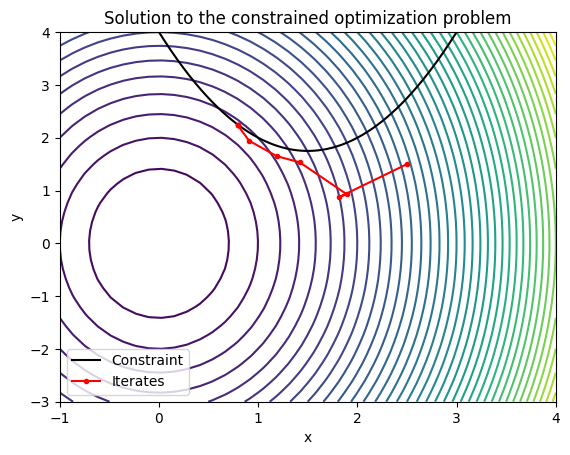

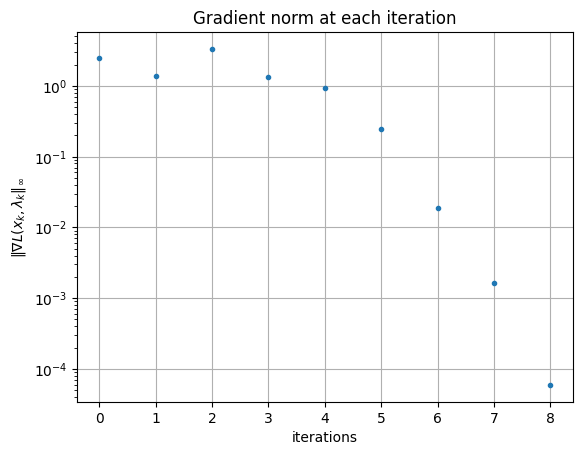

In [11]:
# Create figure handle, plot objective and constraint
plt.figure()
X, Y = np.meshgrid(np.linspace(-1.0, 4.0, 40), np.linspace(-3.0, 4.0, 40))
obj = np.vectorize(lambda x, y: ffun([x, y]))(X, Y)

c = plt.contour(X, Y, obj, 40)
t = np.linspace(-1.0, 4, 400)
plt.plot(t, 3.0 + np.square(t - 1.0) - t, "k", label="Constraint")
plt.xlim([-1.0, 4.0])
plt.ylim([-3.0, 4.0])

# Call the Newton-Lagrange method
x0 = np.array([2.5, 1.5])
_, x, grad_iters = minimize_nl(lambda x: ffun(x), lambda x: hfun(x), x0)

# Plot solution
plt.plot(x[0, :], x[1, :], "r.-", label="Iterates")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution to the constrained optimization problem")
plt.legend()

# Plot the gradient norms
plt.figure()
plt.semilogy(grad_iters, ".")
plt.grid(True)
plt.title("Gradient norm at each iteration")
plt.xlabel("iterations")
plt.ylabel(r"$\|\nabla L(x_k, \lambda_k\|_\infty$")
plt.show()

### Exercise 3: Constrained Gauss-Newton
We now consider a constrained version of the problem in Exercise 1, and we solve it by integrating Gauss-Newton and Newton-Lagrange methods:
\begin{equation} \tag{3.1}
	\min_{x\in\R^n}~f(x)
\quad\text{subject to}\quad
	h(x) = 0.
\end{equation}
Again, we handle the constraints by introducing the Lagrange multipliers $\lambda$ and the Lagrange function
$$
	L(x,\lambda) = \tfrac 12\|F(x)\|_2^2 + \lambda^{\top}h(x)
$$
and use a linear approximation of $F$ and $h$ around $x_k$.
Differently from what we did in Exercise 2, we only linearize the part in $x$:
$$
	L(x_k+\Delta x,\lambda)
{}\approx{}
	\tfrac 12F_k^{\top}F_k + F_k^{\top}J_k\Delta x + \tfrac 12\Delta x^{\top}J_k^{\top}J_k\Delta x + \lambda^{\top}(h_k + Jh_k \Delta x)
$$
where
$$
	h_k\coloneqq h(x_k)
\quad\text{and}\quad
	J_k\coloneqq JF{x_k}.
$$
The *linearized* problem (linearized around $x_k$) therefore is
\begin{equation} \tag{3.2}
	\min_x~\tfrac 12\|F_k + J_k\Delta x\|_2^2
\quad\text{subject to}\quad
	h_k + Jh_k\Delta x = 0.
\end{equation}
The optimality conditions of (3.2) are
$$
	J_k^{\top} J_k \Delta x + J_k^{\top}F_k + Jh_k^{\top} \lambda = 0
\quad\text{and}\quad
	h_k + Jh_k \Delta x = 0,
$$
which can be written in compact form as
\begin{equation}\tag{3.3}
	\left[
		\begin{array}{cc}
			J_k^{\top} J_k & Jh_k^{\top} \\
			Jh_k & 0
		\end{array}
	\right]
	\left(
		\begin{array}{cc}
			\Delta x \\ \lambda
		\end{array}
	\right)
{}={}
	\left(
		\begin{array}{cc}
			- J_k^{\top}F_k \\ -h_k
		\end{array}
	\right).
\end{equation}
By solving (3.3) we obtain $\Delta x$ and $\lambda$.
Once again we use $d_k=\Delta x$ as our search direction and perform a line search to obtain $x_{k+1} = x_k + \alpha_k\,d_k$.
The step length $\alpha_k$ can be computed by employing the same Armijo condition as before, namely
\begin{equation} \tag{3.4}
	\varphi(x_k + \alpha_k d_k) {}\leq{} \varphi(x_k) + \sigma \alpha_k \varphi'(x_k;d_k)
\end{equation}
where $\phi(x)$ is the merit function defined by
\begin{equation} \tag{3.5}
	\varphi(x) {}\coloneqq{} f(x) + c \|h(x)\|_1
\end{equation}
whose directional derivative is
\begin{equation} \tag{3.6}
	\varphi'(x_k;d_k) {}={}	\nabla F_k^{\top}d_k - c \|h_k\|_1.
\end{equation}
Though methods have been developed to adapt $c$ at each iteration, you might start by fixing the value to  $c=100$.

In [12]:
# Redefine merit_fun to accept Ffun, rather than ffun
def merit_fun(Ffun, hfun, c, x):
    """
    Evaluates the merit function (3.5), given the nonlinear function Ffun

    Input arguments:
    - Ffun: vector-valued function
    - hfun: vector-valued constraint function
    - c: penalty parameter, strictly positive
    - x: the current iterate

    Returns:
    - the merit function (2.4) evaluated at x
    """
    F = np.atleast_1d(Ffun(x))
    assert F.ndim == 1, "Ffun should return a 1D array"
    h = np.atleast_1d(hfun(x))
    assert h.ndim == 1, "hfun should return a 1D array"
    return 0.5 * np.dot(F, F) + c * np.linalg.norm(h, ord=1)

**Task 3a**: Implement a Constrained Gauss-Newton minimizer by completing the function *minimize_cgn*.
This minimizer takes in the functions $F(x)$, $h(x)$ and an initial guess $x_0$.
Remember that the provided *line_search* function has a slightly different prototype than last time (to account for the merit function).

Use the stopping criterion: 
$$
    \left\|
        \begin{array}{c}
            \nabla_xL(x_k, \lambda_k) \\ \nabla_\lambda L(x_k, \lambda_k)
        \end{array}
    \right\|_\infty
{}={}
    \left\|
        \begin{array}{c}
            \nabla f_k + Jh_k^{\top} \lambda_k \\ h_k
        \end{array}
    \right\|_\infty
{}<{}
    10^{-4}.
$$


In [13]:
def minimize_cgn(Ffun, hfun, x0):
    """
    minimizes the problem (3.1) using a constrained Gauss-Newton method

    Input arguments:
    - Ffun: the function F, vector-valued
    - hfun: the constraint function h, vector-valued
    - x0: the initial iterate

    Returns:
    - x: Final iterate
    - x_iters: Log of the iterates
    - x_grads: Log of the gradient norms
    """

    # Convergence tolerance
    grad_tol = 1e-4
    max_iters = 600

    # Check that x0 is a 1D array
    x0 = np.asarray(x0)
    assert x0.ndim == 1, "x0 must be a 1D array"

    # Make sure Ffun returns a 1D array
    F0 = np.asarray(Ffun(x0))
    assert F0.ndim == 1, "Ffun must return a 1D array"

    # Make sure that hfun returns a 1D array
    h0 = np.atleast_1d(hfun(x0))
    assert h0.ndim == 1, "hfun must return a 1D array"

    # Iteration logs
    x_iters = np.zeros((len(x0), max_iters))
    f_iters = np.zeros(max_iters)

    # Initialization
    x = np.copy(x0)
    lmbd = np.zeros_like(h0)

    for k in range(max_iters):
        # Check for divergence
        if np.max(abs(x)) > 1e6:
            raise ValueError(f"minimize_cgn has diverged, {np.max(abs(x))=}")

        # Evaluate F and its Jacobian JF
        F, JF = finite_difference_jacob(Ffun, x)
        # Evaluate h and its Jacobian Jh
        h, Jh = finite_difference_jacob(hfun, x)

        # Update iteration log
        norm_grad_L = np.linalg.norm(
            np.concatenate([JF.T @ F + Jh.T @ lmbd, h]), ord=np.inf
        )
        x_iters[:, k] = np.copy(x)
        f_iters[k] = norm_grad_L
        display(Latex(rf"Iteration: {k}, $\|\nabla L\|_\infty$ = {norm_grad_L}"))

        # Check for convergence
        if norm_grad_L < grad_tol:
            return x, x_iters[:, 0 : k + 1], f_iters[0 : k + 1]

        ###################### FILL THIS PART IN ####################
        # Find the search direction and new Lagrange multipliers
        n, m = len(x), len(h)
        B = JF.T @ JF
        M = np.block([[B, Jh.T], [Jh, np.zeros((m, m))]])
        grad_f = JF.T @ F
        search_dir_x_lmbd = np.linalg.solve(M, np.concatenate([-grad_f, -h]))
        dk, lmbd = np.split(search_dir_x_lmbd, [n])

        # Line search
        c = 100
        eval_merit = lambda x: merit_fun(Ffun, hfun, c, x)
        dir_deriv_merit = np.dot(grad_f, dk) - c * np.linalg.norm(h, ord=1)
        x, _ = line_search(eval_merit, x, dir_deriv_merit, dk, sigma=0.01, beta=0.6)

        #############################################################

    raise ValueError("minimize_cgn has diverged, maximum number of iterations reached.")

**Task 3b**: Again, solve the problem
$$
    \min_{x,y}~\tfrac 12\left( x^2 + \left(\frac y2\right)^2 \right)
\quad\text{s.t.}\quad
    y = (x-1)^2 - x + 3
$$
by completing the code below.

Play with the initial guess $x_0$ and see how the convergence is affected.

In [14]:
def Ffun(xy):
    """
    Evaluates the vector-valued function F

    Input arguments:
    - xy: the vector [x, y]

    Returns: F evaluated at xy (= an array)
    """
    x, y = xy
    ###################### FILL THIS PART IN ####################
    F = np.array([x, y / 2])
    #############################################################
    return F


def hfun(xy):
    """
    Evaluates the vector-valued function h

    Input arguments:
    - xy: the vector [x, y]

    Returns: h evaluated at xy (=an array)
    """
    x, y = xy
    ###################### FILL THIS PART IN ####################
    h = np.array([(x - 1) ** 2 - x + 3 - y])
    #############################################################
    return h

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

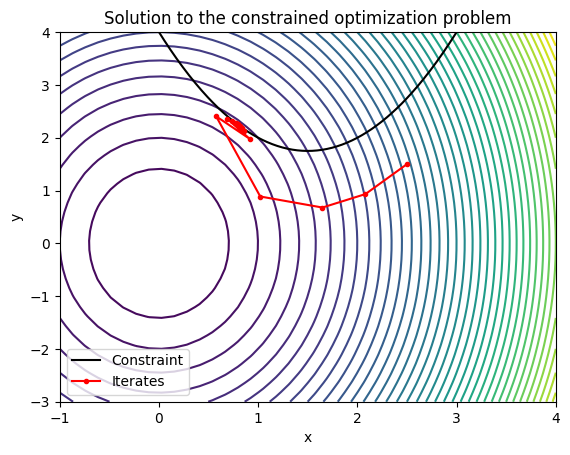

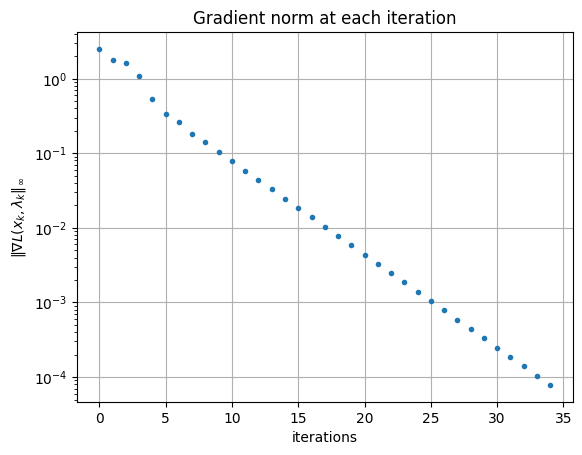

In [15]:
# Create figure handle, plot objective and constraint
plt.figure()
X, Y = np.meshgrid(np.linspace(-1.0, 4.0, 40), np.linspace(-3.0, 4.0, 40))
obj = np.vectorize(lambda x, y: ffun([x, y]))(X, Y)

c = plt.contour(X, Y, obj, 40)
t = np.linspace(-1.0, 4, 400)
plt.plot(t, 3.0 + np.square(t - 1.0) - t, "k", label="Constraint")
plt.xlim([-1.0, 4.0])
plt.ylim([-3.0, 4.0])

# Call the Constrained Gauss-Newton method
x0 = np.array([2.5, 1.5])
_, x, grad_iters = minimize_cgn(lambda x : Ffun(x), lambda x: hfun(x), x0)

# Plot solution
plt.plot(x[0, :], x[1, :], "r.-", label="Iterates")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution to the constrained optimization problem")
plt.legend()

# Plot the gradient norms
plt.figure()
plt.semilogy(grad_iters, ".")
plt.grid(True)
plt.title("Gradient norm at each iteration")
plt.xlabel("iterations")
plt.ylabel(r"$\|\nabla L(x_k, \lambda_k\|_\infty$")
plt.show()
